In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from torch import nn
from sklearn.model_selection import train_test_split

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
data_df = pd.read_excel(r'../../data/custom_data_5.xlsx')

In [43]:
X=data_df.iloc[:,:2].to_numpy(dtype=float)
y = data_df['Color Class'].to_numpy(dtype=float)

In [44]:
X,y = torch.from_numpy(X).type(torch.float).to(device),torch.from_numpy(y).type(torch.float).to(device)

In [45]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [46]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2048, 512, 2048, 512)

In [47]:
X_train.device,X_test.device,y_train.device,y_test.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [48]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.ReLU(),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=20),
    nn.Linear(in_features=20, out_features=1),
    
).to(device)

In [49]:

#loss function 
loss_fn = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [50]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [52]:
epochs = 1000

for epoch in range(epochs):

    model_0.train()

    train_logits=model_0(X_train).squeeze()
    train_pred = torch.round(torch.sigmoid(train_logits))


    train_loss = loss_fn(train_logits,y_train)
    train_acc = accuracy_fn(y_train,train_pred)

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()

    with torch.inference_mode():

        test_logits=model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_pred)

    if test_acc>99:
        print(f'Testing accuracy has reached {test_acc:.2f}%')
        break

    if epoch % 10 == 0 :
        
        print(f'epoch: {epoch}, training loss:{train_loss}, testing loss:{test_loss}, training acc:{train_acc},testing acc:{test_acc}')


epoch: 0, training loss:0.2353060245513916, testing loss:0.23843348026275635, training acc:89.990234375,testing acc:89.84375
epoch: 10, training loss:0.16685731709003448, testing loss:0.17025434970855713, training acc:93.115234375,testing acc:92.1875
epoch: 20, training loss:0.14592993259429932, testing loss:0.15263891220092773, training acc:93.310546875,testing acc:92.7734375
epoch: 30, training loss:0.1315426230430603, testing loss:0.13806402683258057, training acc:94.23828125,testing acc:93.359375
epoch: 40, training loss:0.11623658239841461, testing loss:0.12188270688056946, training acc:94.921875,testing acc:94.53125
epoch: 50, training loss:0.10052153468132019, testing loss:0.10519571602344513, training acc:95.458984375,testing acc:96.09375
epoch: 60, training loss:0.08860854804515839, testing loss:0.0920504629611969, training acc:96.19140625,testing acc:95.8984375
epoch: 70, training loss:0.06838003545999527, testing loss:0.06968823075294495, training acc:97.412109375,testing ac

In [53]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

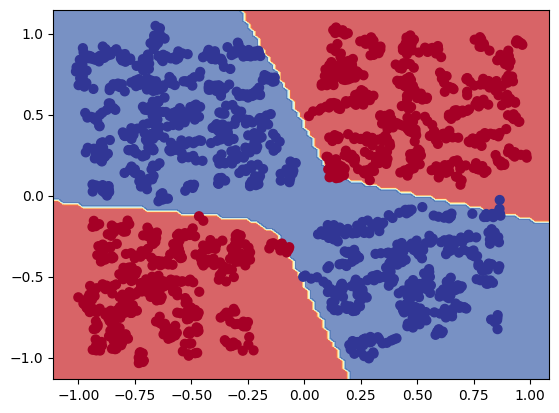

In [54]:
model_1=model_0
plot_decision_boundary(model_1,X_train,y_train)